Import libraries

In [1]:
import torch
torch.cuda.set_device(1)
device = torch.device('cuda:1')

In [2]:
dataPath = '//home/elhamod/CoPhy-PGNN/CoPhy-PGNN/datasets/electromagnetic_dualphase'
folder_name = "/home/elhamod/jiesRepo/Cophy-PGNN/eval_saved/electromagnetic" # Directury where results are
trainingCount= '2000examples_400x400complex.mat' #['dataShort.mat', 'data1000.mat', 'dataFull.mat']

# A dictionary of the name of the model and its type
names=[
    {"name":"BB", "type":"NN"},
    {"name":"CoPhy", "type":"cNSE-NNex"},
]


in_band=[1];
out_of_band=[4,9,16];

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import ntpath

sys.path.append('../scripts/')
from data_loader_electromagnetic import DatasetLoader
from presets import LambdaSearch
from parse_results import parse_results

from config_plots import global_settings
global_settings()
import warnings
warnings.filterwarnings("ignore")

Cuda

In [4]:
device = torch.device('cpu')
print(device)

cpu


In [5]:
def fix_path(dir_, path):
    fixed = os.path.relpath(path, '../')
    return os.path.join(dir_, fixed)

def find_model(name, train_size, target_dir=""):
    result_list = glob.glob(target_dir + '*.txt')
    if len(result_list):
        results = []
        for file in result_list:
            d = parse_results(file)
            if d['name'] == name and d["params"]["data_params"]["train_size"] == train_size:
                results.append(d)
        return results
    else:
        raise RuntimeError(
            "No txt file find under the directory. Please use os.chdir(TARGET DIR) before use it, or specify target_dir parameter."
        )


Hyper parameters

In [6]:
# Model parameters
param_presets = LambdaSearch(data_path=dataPath)
param = param_presets.DNN()
H =  100
Depth = 2

Load data

In [7]:
datasetLoader = DatasetLoader(data_path=dataPath, train_size=trainingCount)
datasetLoader.normalization(x=True, y=False)
datasetLoader.torch_tensor(device=device)

X_train = datasetLoader.X_train_tensor
X_val = datasetLoader.X_val_tensor
X_test = datasetLoader.X_test_tensor
y_train = datasetLoader.y_train_tensor
y_val = datasetLoader.y_val_tensor
y_test = datasetLoader.y_test_tensor
X_scale = datasetLoader.X_scale_tensor
X_mean = datasetLoader.X_mean_tensor
y_scale = datasetLoader.y_scale_tensor
y_mean = datasetLoader.y_mean_tensor
X_trainOrigin = datasetLoader.X_train_origin
X_valOrigin = datasetLoader.X_val_origin
X_testOrigin = datasetLoader.X_test_origin

trainingMag = X_trainOrigin[:, 0]
testMag = X_testOrigin[:, 0]


Load model

In [8]:
from DNN import DNN
import glob
import os
import pandas as pd
import re
from helper_electromagnetic import getBxVsCosineSimilarity, getFittedData, GetStatistics, PlotHelper
import glob

Bx_vs_cosineSimilarity_mean_list = []
Bx_vs_cosineSimilarity_std_list = []
test_x = np.array(in_band + out_of_band)

D_in  = datasetLoader.x_dim
D_out = datasetLoader.y_dim

for name in names:
    DNN_type = name['type']
    name = name['name']
    
    model_files = find_model(name, trainingCount, folder_name+"/results/")
    
    fileList = list(map(lambda x: os.path.join(folder_name, 'models',ntpath.basename(x["model_path"])), model_files)) #glob.glob(folder_name+DNN_type+"/*.pt")

    Bx_vs_cosineSimilarity_list = list()
    for file in fileList:
        model_final = DNN(D_in, H, D_out, Depth).to(device)

        model_final.load_state_dict(torch.load(file, map_location='cpu'))

        Bx_vs_cosineSimilarity = getBxVsCosineSimilarity(testMag, model_final(X_test), y_test)
        Bx_vs_cosineSimilarity_list.append(getFittedData(Bx_vs_cosineSimilarity, test_x))

    (Bx_vs_cosineSimilarity_mean, Bx_vs_cosineSimilarity_std) = GetStatistics(testMag, Bx_vs_cosineSimilarity_list)
    Bx_vs_cosineSimilarity_mean_list.append(Bx_vs_cosineSimilarity_mean)
    Bx_vs_cosineSimilarity_std_list.append(Bx_vs_cosineSimilarity_std)


Plot Cosine similarity

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


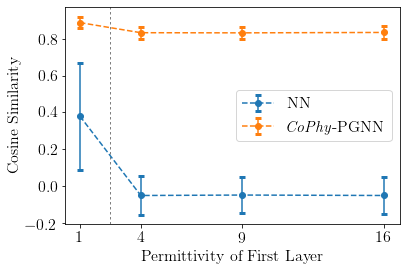

In [9]:
%matplotlib inline 

prettyPlot = PlotHelper("Test data Cosine Similarity vs. Permittivity of First Layer", " Permittivity of First Layer","Cosine Similarity", xticks=test_x, line_location=(in_band[-1] + out_of_band[0])/2)
for i, name in enumerate(names):
    prettyPlot.updatePlotXYSTD(test_x, Bx_vs_cosineSimilarity_mean_list[i], Bx_vs_cosineSimilarity_std_list[i], name['name'], i)

In [10]:
prettyPlot.fig.savefig(os.path.join(folder_name, "CosineSimilarity.pdf"), bbox_inches='tight')